# Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from PIL import Image

#Torch

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
#Torch model
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Processing



### Upload data to colab

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
!gdown --id 1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!unzip /content/wb_recognition_dataset.zip &> /dev/null

The syntax of the command is incorrect.


In [12]:
cnv_local_dir = 'wb_recognition_dataset/wb_recognition_dataset'
colab_dir = '/content/wb_recognition_dataset'
dataset_dir = cnv_local_dir
train_dataset_dir = dataset_dir + '/train'
val_dataset_dir = dataset_dir + '/val'
val_dataset_img_dir = val_dataset_dir + '/images'
annotations_file_dir = val_dataset_dir + '/labels.csv'


In [7]:
# %cd train_dataset
image_folders = os.listdir(train_dataset_dir)
print(image_folders)

['0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '104', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '105', '1050', '1051', '1052', '1053', '1054', '1055', '1056', '1057', '1058', '1059', '106', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '107', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '108', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088', '1089', '109', '1090', '1091', '1092', '1093', '1094', '1095', '1096', '1097', '1098', '1099', '11', '110', '1100', '1101', '1102', '1103', '1104', '1105', '1106', '1107', '1108', '1109', '111', '1110', '1111

### Data Pre-processing

In [8]:

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    # transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 if needed
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

alexnet_transform = transforms.Compose([
    transforms.Resize((227,227)),                  # Resize the image to 256x256
    # transforms.CenterCrop(224),              # Perform a center crop to obtain a square 224x224 image
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


### Load Train and Valid data from directory

In [9]:
# def load_images_from_folder(folder) -> tuple:
#     images = []
#     for filename in os.listdir(folder):
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)

#     label = os.path.basename(folder)
#     return label, images

In [10]:
# train_imgs = []
# train_labels = []
# for folder_name in image_folders:
#     dis_dir = f"{train_dataset_dir}/{folder_name}"
#     label, images = load_images_from_folder(dis_dir)

#     for img in images:
#         train_labels.append(label)
#         train_imgs.append(img)

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = str(self.img_labels.iloc[idx, 0]) + ".jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
chosen_transform = alexnet_transform
train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=chosen_transform)
valid_dataset = CustomImageDataset(annotations_file = annotations_file_dir,
                                  img_dir = val_dataset_img_dir,
                                  transform = chosen_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 227, 227])
Label: 10


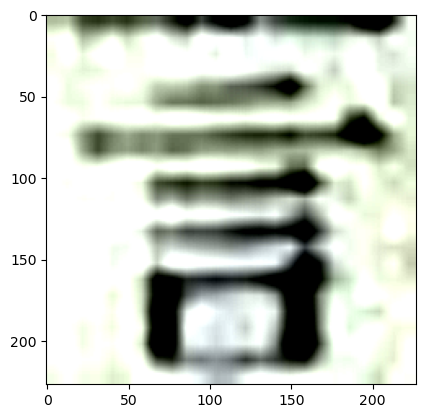

In [14]:
testing_sample_set = valid_dataset
testing_sample_set[0]
# Accessing a single sample
sample_image, sample_label = testing_sample_set[0]
print("Image shape:", sample_image.shape)      # Shape of the image tensor
print("Label:", sample_label)
plt.imshow(testing_sample_set[5][0].permute(1, 2, 0), cmap='gray')

#### DataLoader


In [15]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Iterate over batches in the train loader
for i, (data, labels) in enumerate(train_loader):
    # Print batch size and labels
    print(f"Batch {i}:")
    print("Batch Size:", data.size(0))
    print("Labels:", labels)

    # Visualize some sample images (optional)
    # for i in range(min(4, data.size(0))):  # Visualize up to 4 images from each batch
    #     plt.imshow(data[i].permute(1, 2, 0).squeeze().numpy(), cmap='gray')  # Convert tensor to numpy array
    #     plt.title(f"Label: {labels[i]}")
    #     plt.show()

    break
    # Break after the first batch for demonstration

Batch 0:
Batch Size: 64
Labels: tensor([1115,  656, 1232,   98,  434, 2000,  815, 1600,  154,  283, 1319, 1806,
        1057, 1825, 1966,  577, 1442, 1095, 1504,   38, 1656,  786, 1171,  635,
        1896,  295, 1472,  733, 1042,  566, 1154, 1534,  891, 1367,  496,  730,
        1371, 1775,  546,  539,   78,  179, 1499, 1047, 1944,    8,   70,  812,
         704,  206,  879, 1274, 1787, 2103, 1960, 1756, 1449, 1774, 1944, 1878,
         359,  441,   47,  515])


# Model

### Model Architecture

#### Alexnet (Custom)
Input:
- 3 x 227 x 227

Output:

- 1000 (Base) -> 2130 (Adjusted)


In [17]:

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### Custom Model

In [17]:
class CustomBuiltModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomBuiltModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### Initiate Model

Note: Change the input data transform fuction accordingly to the chosen model


In [18]:
output_classes_num = len(train_dataset.classes)
output_classes_num

2130

In [19]:
# model = models.alexnet(weights='IMAGENET1K_V1')
model = AlexNet(output_classes_num)
# model = CustomBuiltModel(output_classes_num)
model = model.to(device)

# Traning



### Parameter

In [20]:
epochs_num = 2
leaning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=leaning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.5, last_epoch=-1)
total_step = len(train_loader)

### Traning Loop

In [21]:
epochs = 30
history = []
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clean existing gradients
        optimizer.zero_grad()

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        print(i)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()
        scheduler.step()


        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
    # else:
    #     # Validation - No gradient tracking needed
    #     with torch.no_grad():

    #         # Set to evaluation mode
    #         model.eval()

    #         # Validation loop
    #         for j, (inputs, labels) in enumerate(val_loader):
    #             inputs = inputs.to(device)
    #             labels = labels.to(device)

    #             # Forward pass - compute outputs on input data using the model
    #             outputs = model(inputs)

    #             # Compute loss
    #             loss = criterion(outputs, labels)

    #             # Compute the total loss for the batch and add it to valid_loss
    #             valid_loss += loss.item() * inputs.size(0)

    #             # Calculate validation accuracy
    #             ret, predictions = torch.max(outputs.data, 1)
    #             correct_counts = predictions.eq(labels.data.view_as(predictions))

    #             # Convert correct_counts to float and then compute the mean
    #             acc = torch.mean(correct_counts.type(torch.FloatTensor))

    #             # Compute total accuracy in the whole batch and add to valid_acc
    #             valid_acc += acc.item() * inputs.size(0)

    #             #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    #     # Find average training loss and training accuracy
    #     avg_train_loss = train_loss/len(train_dataset)
    #     avg_train_acc = train_acc/float(len(train_dataset))

    #     # Find average training loss and training accuracy
    #     avg_valid_loss = valid_loss/len(val_dataset)
    #     avg_valid_acc = valid_acc/float(len(val_dataset))

    #     history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    #     epoch_end = time.time()

    #     print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Epoch: 1/30
0
Batch number: 000, Training: Loss: 7.6761, Accuracy: 0.0000
1
Batch number: 001, Training: Loss: 21.2577, Accuracy: 0.0000
2
Batch number: 002, Training: Loss: 16.1850, Accuracy: 0.0000
3
Batch number: 003, Training: Loss: 11.9428, Accuracy: 0.0000
4
Batch number: 004, Training: Loss: 10.1342, Accuracy: 0.0000
5
Batch number: 005, Training: Loss: 8.5136, Accuracy: 0.0000
6
Batch number: 006, Training: Loss: 7.6967, Accuracy: 0.0000
7
Batch number: 007, Training: Loss: 7.8438, Accuracy: 0.0000
8
Batch number: 008, Training: Loss: 7.5853, Accuracy: 0.0000
9
Batch number: 009, Training: Loss: 7.7086, Accuracy: 0.0000
10
Batch number: 010, Training: Loss: 7.6641, Accuracy: 0.0156
11
Batch number: 011, Training: Loss: 7.7329, Accuracy: 0.0000
12
Batch number: 012, Training: Loss: 7.6917, Accuracy: 0.0000
13
Batch number: 013, Training: Loss: 7.7078, Accuracy: 0.0000
14
Batch number: 014, Training: Loss: 7.6956, Accuracy: 0.0000
15
Batch number: 015, Training: Loss: 7.6356, Acc

KeyboardInterrupt: 

In [ ]:
for epoch in range(epochs_num):
  epoch_start = time.time()

  # Loss and Accuracy within the epoch
  train_loss = 0.0
  train_acc = 0.0

  valid_loss = 0.0
  valid_acc = 0.0

  """
  Training section
  """
  #Set model to traning mode
  model.train()

  for i, data in enumerate(train_loader):
    images = data[0].to(device)
    labels = data[1].to(device)

    # Clear the previous gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)

    # Calculate loss
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    #Update the learning rate scheduler
    scheduler.step()

    # Print training statistics
    train_loss += loss.item()
    if i % 100 == 99:    # Print every 100 mini-batches
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, epochs_num, i+1, total_step, loss.item()))


  """
  Validation section
  """

  epoch_end = time.time()

print('Finished Training')